In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
from IPython.core.pylabtools import figsize

import os, sys, time
import json
import numpy as np
import pandas as pd
import numpy.random as nr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import torchvision as tv
import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


# DCGAN: Deep Convolutional Generative Adversarial Network

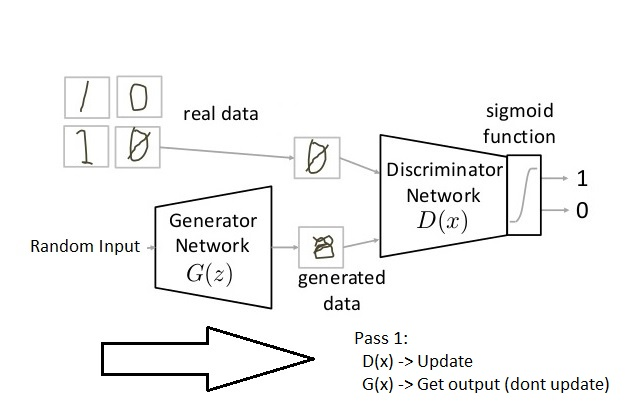

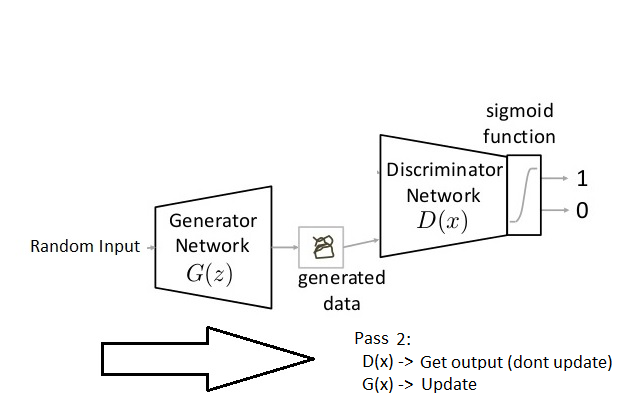

## Dataset MNIST 

In [10]:
def get_mnist_data_loader(batch_size):
    train_ds = tv.datasets.MNIST('/data/datasets/MNIST/', train=True, 
                                 transform=tv.transforms.ToTensor())
    print('Número de amostras no dataset (treino):', len(train_ds))
    train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    return train_dloader

## Definição das redes adversárias

In [11]:
# ---------------------------
# Imagens nc x 28 x 28
# ---------------------------

class GNet(nn.Module):
    def __init__(self, nz, nc, ngf=64):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        output = self.main(input)
        return output


class DNet(nn.Module):
    def __init__(self, nc, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


## Preparação para o treino

In [12]:
latent_dim = 100
batch_size = 50
image_size = 28
image_chan = 1

train_dloader = get_mnist_data_loader(batch_size)

Número de amostras no dataset (treino): 60000


In [13]:
train_it = True
niter = 100
save_interval = 10
print_interval = 10

# build the networks
d_net = DNet(nc=image_chan, ndf=64)
g_net = GNet(nz=latent_dim, nc=image_chan, ngf=64)

# make our input tensors
d_input = torch.FloatTensor(batch_size, image_chan, image_size, image_size)
noise = torch.FloatTensor(batch_size, latent_dim, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
if use_gpu:
    d_net.cuda()
    g_net.cuda()
    d_input, label = d_input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
fixed_noise = Variable(fixed_noise)
real_label = 1
fake_label = 0


# setup optimizer
opt_lr = 0.0002
opt_beta1 = 0.5
D_optimizer = Adam(d_net.parameters(), lr=opt_lr, betas=(opt_beta1, 0.999))
G_optimizer = Adam(g_net.parameters(), lr=opt_lr, betas=(opt_beta1, 0.999))

# and cost function
criterion = nn.BCELoss()

## Treinamento

In [14]:
def plot_samples(samples):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples[:25]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

In [15]:
if train_it:
    try:
        for epoch in range(niter+1):
            t0 = time.time()
            for i, (x_real, _) in enumerate(train_dloader):
                curr_batch_size = x_real.size(0)
                # -----------------------------------------------------------
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                # -----------------------------------------------------------
                d_net.zero_grad()

                # train with real        
                if use_gpu:
                    x_real = x_real.cuda()
                d_input.resize_as_(x_real).copy_(x_real)
                label.resize_(curr_batch_size).fill_(real_label)
                inputv = Variable(d_input)
                labelv = Variable(label)

                output = d_net(inputv)
                d_error_real = criterion(output, labelv)
                d_error_real.backward()
                d_x = output.data.mean()

                # train with fake
                noise.resize_(batch_size, latent_dim, 1, 1).normal_(0, 1)
                noisev = Variable(noise)
                labelv = Variable(label.fill_(fake_label))

                fake_data = g_net(noisev)
                # detach() cria nova variável com mesmo conteúdo mas 
                # desconectada do grafo criado por g_net.forward(...)
                fake_data_2 = fake_data.detach()
                output = d_net(fake_data_2)
                d_error_fake = criterion(output, labelv)
                d_error_fake.backward()
                d_g_z1 = output.data.mean()

                d_error = d_error_real + d_error_fake
                D_optimizer.step()

                # -------------------------------------------
                # (2) Update G network: maximize log(D(G(z)))
                # -------------------------------------------
                g_net.zero_grad()

                # fake labels are real for generator cost
                labelv = Variable(label.fill_(real_label))

                output = d_net(fake_data)
                g_error = criterion(output, labelv)
                g_error.backward()

                d_g_z2 = output.data.mean()
                G_optimizer.step()

            if epoch % print_interval == 0:
                print('{:3d}: {:.4f} {:.4f}  [{:.2f}s]'.format(epoch, d_error.data[0], 
                                                                      g_error.data[0], time.time() - t0))

            if epoch % save_interval == 0:
                fake_data = g_net(fixed_noise)
                fig = plot_samples(fake_data.data.cpu().numpy())
                plt.savefig('../../images/dcgan_img_{:04d}.png'.format(epoch, bbox_inches='tight'))
                plt.close(fig)

    except KeyboardInterrupt:
        print('Interrupted!')

  0: 1.6968 0.2919  [58.52s]
 10: 0.5220 2.3638  [58.52s]
Interrupted!


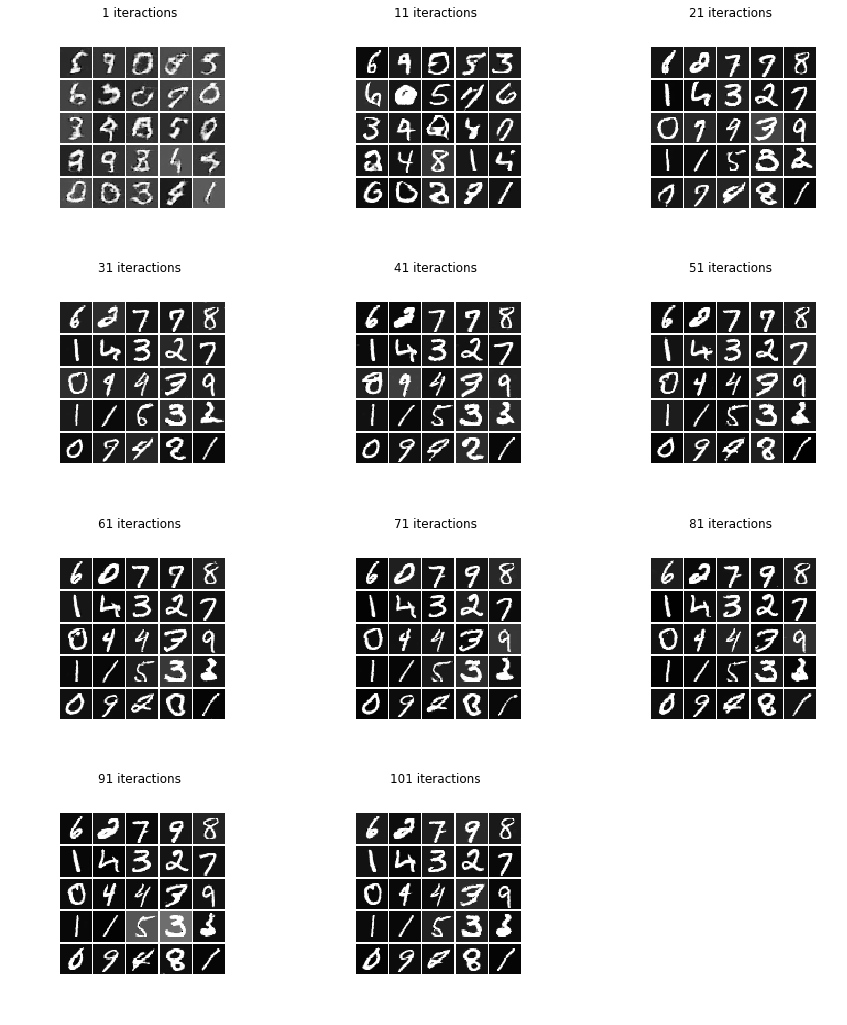

In [16]:
fig = plt.figure(figsize=(15, 18))

for i, fn in enumerate(range(0, niter+1, save_interval)):
    fig.add_subplot(4, 3, i+1)
    image_fn = '../../images/dcgan_img_{:04d}.png'.format(fn)
    img = plt.imread(image_fn)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('{} iteractions'.format(fn+1))
 